In [17]:
print('hello world')
import pandas as pd
import re
from sklearn.model_selection import train_test_split
from collections import defaultdict, Counter

# load the csv file
data = pd.read_csv('./sms_smpa_collection/SMSSpamCollection',
                   sep='\t', 
                   header=None,
                   names=['label', 'message'])
data.head()

hello world


,label,message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [21]:
def process_data(text):
    # convert to lower case
    text = text.lower()
    # remove punctuation and special character
    text = re.sub(r'[^a-z0-9\s]', '', text)
    tokens = text.split()
    return tokens

data['tokens'] = data['message'].apply(process_data)
data.head()

,label,message,tokens
0,ham,"Go until jurong point, crazy.. Available only ...","[go, until, jurong, point, crazy, available, o..."
1,ham,Ok lar... Joking wif u oni...,"[ok, lar, joking, wif, u, oni]"
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,"[free, entry, in, 2, a, wkly, comp, to, win, f..."
3,ham,U dun say so early hor... U c already then say...,"[u, dun, say, so, early, hor, u, c, already, t..."
4,ham,"Nah I don't think he goes to usf, he lives aro...","[nah, i, dont, think, he, goes, to, usf, he, l..."


In [29]:
# split the data into 80% train and 20% test
train_data, test_data = train_test_split(
    data,
    test_size=0.2,
    random_state=42,
    # stratify the data by label
    stratify=data['label']
)


# impoment the MLE naive bayues classifier
def train_mle_data(train_data):
    
    # count clas priors
    n_spam = sum(train_data['label'] == 'spam')
    n_ham = sum(train_data['label'] == 'ham')
    n_total = len(train_data)
    
    
    pi_spam = n_spam / n_total
    pi_ham = n_ham / n_total
    
    # let us count word frequencies in each class
    words_spam = []
    words_ham = []
    
    for _, row in train_data.iterrows():
        if row['label'] == 'spam':
            words_spam.extend(row['tokens'])
        else:
            words_ham.extend(row['tokens'])
            
    count_spam = Counter(words_spam)
    count_ham = Counter(words_ham)
    
    # Total word counts
    total_words_spam = sum(count_spam.values())
    total_words_ham = sum(count_ham.values())
    
    return {
        'pi_spam': pi_spam,
        'pi_ham': pi_ham,
        'count_spam': count_spam,
        'count_ham': count_ham,
        'total_words_spam': total_words_spam,
        'total_words_ham': total_words_ham,
        'all_words': set(count_spam.keys()).union(set(count_ham.keys()))
    }
    
    
trained_mle_model = train_mle_data(train_data)

trained_mle_model.keys()
        
    

dict_keys(['pi_spam', 'pi_ham', 'count_spam', 'count_ham', 'total_words_spam', 'total_words_ham', 'all_words'])

In [35]:
import math

def mle_predict(model, tokens):
    log_spam = math.log(model['pi_spam'])
    log_ham = math.log(model['pi_ham'])
    
    for token in tokens:
        # if the word is not sses, the probability = 0 means that the log of probability = -infinity
        
        # to avoid eroors, we will skip words which are not in all_words
        
        if token not in model['all_words']:
            continue
        
        # word probabilites without smoothing
        p_word_spam = model['count_spam'][token] / model['total_words_spam'] if token in model['count_spam'] else 0
        p_word_ham = model["count_ham"][token] / model['total_words_ham'] if token in model['count_ham'] else 0
    
        if p_word_spam > 0:
            log_spam += math.log(p_word_spam)

        else:
            # make it 0 if no spam 
            log_spam += -99999    
            

        if p_word_ham > 0:
            log_ham += math.log(p_word_ham)
            
        else:
            log_ham += -999999
            
            
    return 'spam' if log_spam > log_ham else 'ham'  



    

In [43]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

def evaluate_mle_model(model, test_data):
    preds = []
    for _, row in test_data.iterrows():
        pred = mle_predict(model, row['tokens'])
        preds.append(pred)
        
    y_true = test_data['label']
    
    # return performance metrics
    return {
        'Accuracy': accuracy_score(y_true, preds),  
        'Precision': precision_score(y_true, preds, pos_label='spam'),
        'Recall': recall_score(y_true, preds, pos_label='spam'),
        'F1 score': f1_score(y_true, preds, pos_label='spam')
    }

results_mle = evaluate_mle_model(trained_mle_model, test_data)
results_mle





{'Accuracy': 0.9479820627802691,
 'Precision': 0.7486338797814208,
 'Recall': 0.9194630872483222,
 'F1 score': 0.8253012048192772}

In [ ]:
# train the MAP 
# USE laplace smoothing

def train_map (train_data, alpha=1):
    # we reuse MLE counts we found before
    model= train_mle_data(train_data)
    
    V = len(model['all_words'])
    model['alpha'] = alpha
    model['V'] = V
    
    return model

# trian our map model
map_model = train_map(train_data)

In [40]:
# prediction function for MLE
import math

def map_prediction (model, tokens):
    log_spam = math.log(model['pi_spam'])
    log_ham = math.log(model['pi_ham'])
    
    alpha = model['alpha']
    V = model['V']
    
    for token in tokens:
        
        # compute smoothed probabilites
        log_spam += math.log((model['count_spam'].get(token, 0) + alpha) / (model['total_words_spam'] + alpha * V))
        log_ham += math.log((model['count_ham'].get(token, 0) + alpha) / (model['total_words_ham'] + alpha * V))

    return 'spam' if log_spam > log_ham else 'ham'

In [ ]:
# evalute the map model
def evaluate_map_model(model, test_data):
    preds = []
    
    for _,row in test_data.iterrows():
        preds.append(map_prediction(model, row['tokens']))
        
        y_true = test_data['label']
        
    # return the metrics 
    return{
        "Accuracy": accuracy_score(y_true, preds),
        "Precision": precision_score(y_true, preds, pos_label="spam"),
        "Recall": recall_score(y_true, preds, pos_label="spam"),
        "F1 Score": f1_score(y_true, preds, pos_label="spam")
    }
    
map_results = evaluate_map_model(map_model, test_data)
map_results

{'Accuracy': 0.9802690582959641,
 'Precision': 0.9150326797385621,
 'Recall': 0.9395973154362416,
 'F1 Score': 0.9271523178807947}

In [45]:
# now let us compare mle and map

comparison = pd.DataFrame({
    'MLE': results_mle,
    'MAP': map_results
    
})

comparison

,MLE,MAP
Accuracy,0.947982,0.980269
Precision,0.748634,0.915033
Recall,0.919463,0.939597
F1 score,0.825301,NaN
F1 Score,NaN,0.927152


Discussion of MLE VS MAP PERFOMANCE

- How did incorporating prior knowledge in MAP affect the predictions ?

Including prior knowleger through the laplace smoothing (in MAP) has prevented zero probabilites for words that are rater or did not appear in the training data. this is differnt to mle which assigned zere probabilites to unseen words and led to over confident prodictions based on limited observations. MAP predictions were more stable

- Were there any significant changes in the classification of messages between MLE and MAP?

Yes, some borderline cases changed. Messages that contained rare rworeds of combinatioes which are not present in training dataset were not well classified in MLE because theri likelelhood was assigned as zero. MAP, used smnoothed probabilites aand it correclty classifieds such messages.

What factors might account for differences in the performance metrics?
- Data sparsity: Many words appear only once or twice; MLE treats them as strong evidence, while MAP softens their influence.
- Prior smoothing strength (α): The value of the Laplace parameter determines how much the model trusts prior information versus the observed data.

In [ ]:
# vary the pior to see the observations

alphas = [0.1, 0.5, 1, 5]
records = []

for a in alphas:
    model = train_map(train_data, alpha=a)
    results = evaluate_map_model(model, test_data)
    results["alpha"] = a
    records.append(results)

# voiew the records for differtn values of alpha to study the effect of changing alaphs
alpha_table = pd.DataFrame(records)
alpha_table



,Accuracy,Precision,Recall,F1 Score,alpha
0,0.983857,0.922581,0.959732,0.940789,0.1
1,0.978475,0.898089,0.946309,0.921569,0.5
2,0.980269,0.915033,0.939597,0.927152,1.0
3,0.965022,0.958333,0.771812,0.855019,5.0


Discussion of Findings (Varying the Prior)

- for very small alphas like 0.1, MAP behaves almost like MLE. Probabilities of unseen words remain close to zero, which can still cause over-confident decisions.

- For moderate alpha (≈ 1), the classifier becomes more balanced, achieving the best compromise between accuracy and recall.

- For large alphs (≥ 5), the smoothing dominates; probabilities of all words become similar, reducing the model’s ability to distinguish spam from ham. Accuracy and F1 score slightly decrease.

REFLECTION

When to prefer MLE or MAP

- I may prefer to use MLE when there is much data and the dataset is representative of future samples. This is because it uses only observed evidence and gives unbiased parameter estimates.

- I may prefer to use MAP when data are limited, noisy, or unbalanced, or when prior information is available. It stabilizes learning by introducing regulated bias toward reasonable parameter values.


Impact of using prior infomation

In this case we added prior information using laplace smoothing. it helped to handle unseed words. It ensured that every event has a none-zero probability, and it avoided overfitting. This gave us a smooth and realistic prediction.


VALUE OFR REAL-WORLD APPLICATION

- In spam detection, MAP prevents zero-probability errors when new words appear. This reduces to chances of classifying an image as not spam only because the words were new.

- In medical models, when the data is scarce, MAP helps in utilizing expert or prior knowledge.




# Question 4 part 2

In [22]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_california_housing
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error



# fetch the housing data

housing = fetch_california_housing(as_frame=True)
data = housing.frame


data.head()




,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,MedHouseVal
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23,4.526
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22,3.585
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24,3.521
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25,3.413
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25,3.422


In [11]:
# introduce the noise by selecting averooma and adding gaussina noise

# select averooms
x_original = data[['AveRooms']]
y_original = x_original.copy()

# add gaussina noise with the mean = 0 and sd = 0.5

np.random.seed(42)
noise = np.random.normal(0, 0.5, size = len(y_original))
y_noisy = y_original['AveRooms']+noise


# now combine our data with our new noisy formed signal
# in reeal application like sensors, noise often follows gaussinal distribution centered around zero
data_noise = pd.DataFrame({
    'Original': y_original['AveRooms'],
    'Noisy': y_noisy
})

data_noise.head()


,Original,Noisy
0,6.984127,7.232484
1,6.238137,6.169005
2,8.288136,8.611980
3,5.817352,6.578867
4,6.281853,6.164777


In [19]:
# split our data intor training and test set
# let y be observed (noisy) variable and x be the true singal

y_obs = y_noisy.values.reshape(-1,1)
X_true = y_original.values.reshape(-1, 1)

# let us split the sat now 80% for training
x_train, x_test, y_train, y_test = train_test_split(
    y_obs,X_true, test_size=0.2, random_state=42
)

# downsample test set pints for good visualization
sample_idx = np.random.choice(len(x_test), 200, replace=False)
X_test_sample = x_test[sample_idx]
Y_test_sample = y_test[sample_idx]


# now let us apply the linear regression estimatero

# fit the linear regression modle
model = LinearRegression()
model.fit(x_train, y_train)


# let us now do the prediciono on the text data then do evaluation 

y_pred = model.predict(x_test)



In [23]:
# evaluate the ESTIMATOR
# Compute metrics
bias = np.mean(y_pred - x_test)
variance = np.var(y_pred)
mse = mean_squared_error(x_test, y_pred)


print("Estimator Performance:")
print(f"Bias      : {bias:.4f}")
print(f"Variance  : {variance:.4f}")
print(f"MSE       : {mse:.4f}")

Estimator Performance:
Bias      : -0.0012
Variance  : 7.4141
MSE       : 0.0147


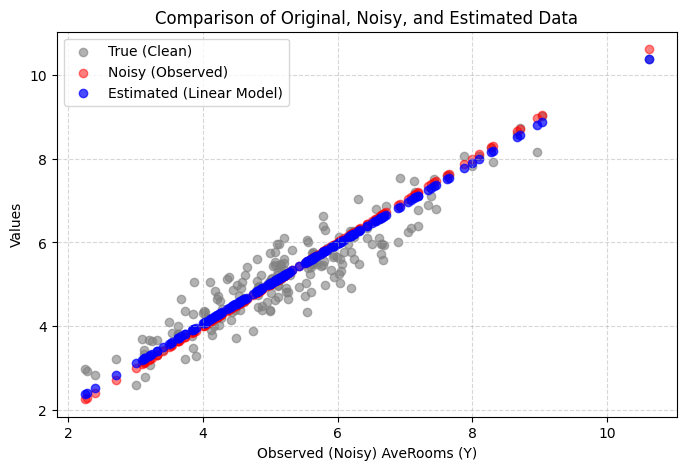

In [24]:
plt.figure(figsize=(8,5))
plt.scatter(X_test_sample, Y_test_sample, color='gray', label='True (Clean)', alpha=0.6)
plt.scatter(X_test_sample, X_test_sample, color='red', label='Noisy (Observed)', alpha=0.5)
plt.scatter(X_test_sample, model.predict(X_test_sample), color='blue', label='Estimated (Linear Model)', alpha=0.7)

plt.xlabel("Observed (Noisy) AveRooms (Y)")
plt.ylabel("Values")
plt.title("Comparison of Original, Noisy, and Estimated Data")
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()


DISCUSSION

1. Bias and Variance

The bias calculated was close to zero. this shows that the estimator doest not systematically overestimate or underestimate the true values.The variance shows how the estimates fluctuate around their mean.  The variance and mse are the indicatores that linear regression reduces noise and preserves the underlying pattern.

2. impact of noise

Introducing the gaussina noise imitates the real-world errors. For example, enviromnetal sensor fluctuation or imperfect data entry. The estimatore reduces the impact of this noise by averaging it our in samples. However, higher noise vaiance can lead to learger erros and flatter reglression slots. This means that the model becomes less sensitive to small changes in Y.

3. Model Limitation

Linear regression assumes a simple linear relationship between the noisy observation y and the true value x.
Practicallt, relationships between noisy and clean data can be nonlinear. For example, sensor saturation, scaling efffect, or bounded variables might require polynomial regression for a better recovery.

If noise characteristics are non-Gaussian, the lineamr estimator may no loger be optimal. In such cases, modles like kalman filters, Bayesian estimatores, or other nonlinear regressions can provide better results.